In [1]:
import os
import gc
import warnings

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
import scipy as sp
%matplotlib inline

In [2]:
TOTAL_DAYS = 1913 + 28 * 2
ENC_LEN = 28
DEC_LEN = 28
LAGS = [28]
TRAIN_LAST_DAY = 1913
FIRST_DAY = datetime(2011, 1, 29) 
FORECAST_DAY = datetime(2016,4, 25) 

CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "int16", 'snap_TX': 'int16', 'snap_WI': 'int16' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [3]:
def load_data(dir_path, first_day=1200, nrows=None):  
    label_encoders = {}

    prices = pd.read_csv(os.path.join(dir_path, "sell_prices.csv"), dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(prices[col].astype(str).fillna("None"))
            prices[col] = label_encoders[col].transform(prices[col].astype(str).fillna("None")).astype("int16")


    cal = pd.read_csv(os.path.join(dir_path, "calendar.csv"), dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(cal[col].astype(str).fillna("None"))
            cal[col] = label_encoders[col].transform(cal[col].astype(str).fillna("None")).astype("int16")

    start_day = max(1, first_day-max(LAGS))
    numcols = [f"d_{day}" for day in range(start_day, TRAIN_LAST_DAY+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv(os.path.join(dir_path, "sales_train_validation.csv"), 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)

    for col in catcols:
        if col != "id":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(dt[col].astype(str).fillna("None"))
            dt[col] = label_encoders[col].transform(dt[col].astype(str).fillna("None")).astype("int16")

    for day in range(TRAIN_LAST_DAY+1, TRAIN_LAST_DAY+28+1):
        dt[f"d_{day}"] = np.nan
    
    product = dt[catcols].copy()

    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")

    dt = dt.merge(cal[['d', 'wm_yr_wk']], on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    dt['d'] = dt['d'].str.replace('d_', '').astype(int)
    price = dt.pivot(index="id", columns="d", values="sell_price")
    xy = dt.pivot(index="id", columns="d", values="sales")
    del dt; gc.collect()

    cal_use_col = ['date', 'wday', 'month', 'year', 'event_name_1',
    'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
    'snap_WI']
    cal = cal[cal_use_col]
    cal['year'] = cal['year'] - cal['year'].min()
    cal['quarter'] = cal.date.dt.quarter
    cal = cal.drop("date", axis=1).T
    cal = cal[xy.columns]
    
    submission = pd.read_csv(os.path.join(dir_path, "sample_submission.csv"))
    
    return xy, price, cal, product, submission

In [4]:
df_xy, df_price, df_calendar, df_product, df_sub = load_data('./data', first_day=1200)

In [5]:
print(df_xy.shape)
df_xy.head()

(30490, 770)


d,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,...,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941
id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001_CA_1_validation,0.0,1.0,6.0,2.0,0.0,3.0,1.0,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOODS_1_001_CA_2_validation,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOODS_1_001_CA_3_validation,0.0,2.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOODS_1_001_CA_4_validation,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOODS_1_001_TX_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print(df_price.shape)
df_price.head()

(30490, 770)


d,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,...,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941
id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001_CA_1_validation,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_001_CA_2_validation,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_001_CA_3_validation,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_001_CA_4_validation,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_001_TX_1_validation,2.24,2.24,2.24,2.24,2.24,0.99,0.99,0.99,0.99,0.99,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24


In [7]:
print(df_calendar.shape)
df_calendar.head()

(11, 770)


,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,...,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941
wday,4,5,6,7,1,2,3,4,5,6,...,1,2,3,4,5,6,7,1,2,3
month,4,4,4,4,4,4,4,4,4,4,...,5,5,5,5,5,5,5,5,5,5
year,3,3,3,3,3,3,3,3,3,3,...,5,5,5,5,5,5,5,5,5,5
event_name_1,30,30,30,30,30,4,30,21,30,30,...,30,30,30,30,30,30,30,30,30,30
event_type_1,4,4,4,4,4,0,4,2,4,4,...,4,4,4,4,4,4,4,4,4,4


In [8]:
print(df_product.shape)
df_product.head()

(30490, 6)


,id,item_id,dept_id,store_id,cat_id,state_id
0,HOBBIES_1_001_CA_1_validation,1437,3,0,1,0
1,HOBBIES_1_002_CA_1_validation,1438,3,0,1,0
2,HOBBIES_1_003_CA_1_validation,1439,3,0,1,0
3,HOBBIES_1_004_CA_1_validation,1440,3,0,1,0
4,HOBBIES_1_005_CA_1_validation,1441,3,0,1,0


In [9]:
print(df_sub.shape)
df_sub.head()

(60980, 29)


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 缺失数据

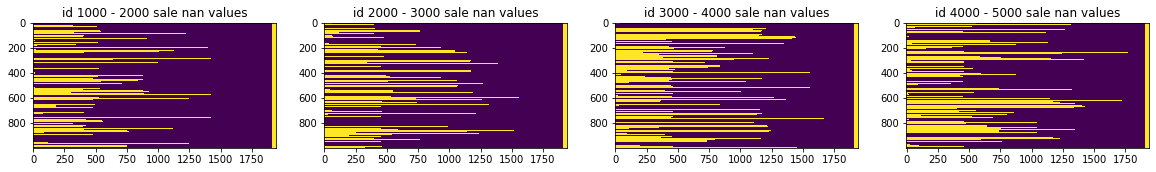

In [187]:
plt.figure(figsize=(20,20))

for i in range(1, 5):
    plt.subplot(int(f'14{i}'))
    plt.imshow(df_xy.isnull().values.astype(int)[i * 1000: (i+1)*1000])
    plt.title(f"id {i * 1000} - {(i+1) * 1000} sale nan values")

In [182]:
id_not_sell = df_xy.isnull().values.astype(int)
id_not_sell[:, -28:] = 0

Text(0.5, 1.0, 'each series num of nan')

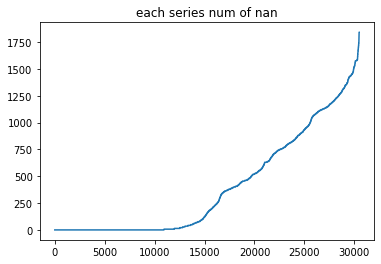

In [183]:
plt.plot(np.sort(id_not_sell.sum(axis=1)))
plt.title("each series num of nan")

In [203]:
pd.Series(id_not_sell.sum(axis=1)).describe()

count    30490.000000
mean       403.391702
std        476.005658
min          0.000000
25%          0.000000
50%        154.000000
75%        763.000000
max       1841.000000
dtype: float64

没有销售，同样没有价格

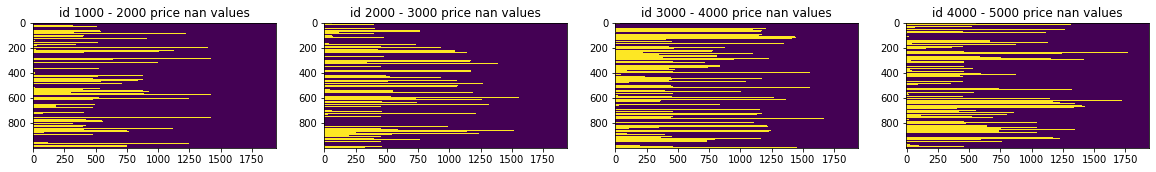

In [188]:
plt.figure(figsize=(20,20))

for i in range(1, 5):
    plt.subplot(int(f'14{i}'))
    plt.imshow(df_price.isnull().values.astype(int)[i * 1000: (i+1)*1000])
    plt.title(f"id {i * 1000} - {(i+1) * 1000} price nan values")

## 数据处理

- 序列状态
- 序列统计指标
- 序列标准化

In [21]:
# series

xy = np.log1p(df_xy.values)

/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
# series state

start_sell = np.argmin(np.isnan(xy), axis=1)
xy_not_sell = np.zeros_like(xy)
for row, start in enumerate(start_sell):
    xy_not_sell[row][:start] = 1

del start_sell; gc.collect()

xy_nan = np.isnan(xy).astype(int)
xy_zero = (xy == 0).astype(int)

In [23]:
# series statistics

xy_valid_masked = np.ma.masked_array(xy, mask=xy_not_sell.astype(bool) | xy_nan.astype(bool))

id_mean = xy_valid_masked.mean(axis=1).data
id_std = xy_valid_masked.std(axis=1).data
id_skew = sp.stats.mstats.skew(xy_valid_masked, axis=1).data
id_kurt = sp.stats.mstats.kurtosis(xy_valid_masked, axis=1).data

In [24]:
# series normalization

xy = (xy - np.expand_dims(id_mean, 1)) / (np.expand_dims(id_std, 1) + 1e-6)
id_mean = (id_mean - id_mean.mean()) / id_mean.std()
id_std = (id_std - id_std.mean()) / id_std.std()
id_skew = (id_skew - id_skew.mean()) / id_skew.std()
id_kurt = np.clip(id_kurt, None, np.percentile(id_kurt, 99))
id_kurt = (id_kurt - id_kurt.mean()) / id_kurt.std()

In [73]:
# fillna xy nan
xy = np.nan_to_num(xy, 0.)

## 特征

### 时间序列状态
- 11_is_sell: 是否销售
- 10_is_zero: 是否为0销售
- 10_continue_zero: 为0第N天
- 10_lag_N：前N天销量
- 10_lag_M_rolling_N_mean/std: 窗口统计
- 品类销量
- 日期类

### 序列统计
- id 均值/中位数/偏度/峰度/分位数
- 365/90/30 自相关系数
- 品类下的日销排名/波动排名
- 品类下的价格排名

In [56]:
id_cat_property = df_product.set_index("id").values
id_num_property = np.stack([id_mean, id_std, id_skew, id_kurt], axis=1)

In [83]:
def create_lags(xy, n_lags):
    r = []
    for l in n_lags:
        lag = np.zeros_like(xy)
        lag[:, l:] = xy[:, :-l]
        r.append(lag)
    return np.stack(r, axis=1)

id_lags = create_lags(xy, LAGS)

In [85]:
df_price

d,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,...,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941
id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001_CA_1_validation,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_001_CA_2_validation,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_001_CA_3_validation,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_001_CA_4_validation,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
FOODS_1_001_TX_1_validation,2.24,2.24,2.24,2.24,2.24,0.99,0.99,0.99,0.99,0.99,...,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24,2.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_516_TX_2_validation,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,...,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94
HOUSEHOLD_2_516_TX_3_validation,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,...,0.99,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94
HOUSEHOLD_2_516_WI_1_validation,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,...,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94,5.94


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
calendar = pd.read_csv("./data/calendar.csv").pipe(reduce_mem_usage)
price = pd.read_csv("./data/sell_prices.csv").pipe(reduce_mem_usage)
sale = pd.read_csv("./data/sales_train_validation.csv").pipe(reduce_mem_usage)
submission = pd.read_csv("./data/sample_submission.csv").pipe(reduce_mem_usage)

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to  2.09 Mb (84.5% reduction)


In [20]:
calendar.wm_yr_wk.max()

11621

In [22]:
price.wm_yr_wk.max()

11621

In [24]:
calendar[calendar.wm_yr_wk == 11621]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


In [16]:
calendar.shape

(1969, 14)

In [7]:
price.head(2)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125


In [9]:
sale.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [10]:
submission.head(2)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 特征

### 时间序列状态
- 10_is_pad: 是否销售
- 10_is_zero: 是否为0销售
- 10_cum_zero: 连续销售为0第N天
- 

In [14]:
series_property = pd.DataFrame({"id": sale.id.unique()})
series_property = series_property.merge(sale[['id', 'item_id', 'dept_id', 'cat_id', 'store_id']], how='left')

In [27]:
id_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sale.drop(id_cols, axis=1, inplace=True)
sale.set_index("id", inplace=True)

In [52]:
pad_end = np.argmin((sale == 0).values, axis=1)
is_zero = (sale == 0).values.astype(int)

for row, end in enumerate(pad_end):
    is_pad[row][:end] = 1
is_pad = np.zeros_like(sale)

In [69]:
mask_series.mean(axis=1)

masked_array(data=[0.5928853754940712, 0.27853107344632766,
                   0.3564356435643564, ..., 0.895397489539749,
                   0.7207392197125256, 1.6973180076628354],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [98]:
sale = sale.apply(np.log1p)
mask_series = np.ma.array(sale.values, mask=is_pad)

# 统计特征 skew kurt

mu = mask_series.mean(axis=1).values
std = mask_series.std(axis=1).values
q5 = np.nanpercentile(mask_series.filled(np.nan), 5)
q95 = np.nanpercentile(mask_series.filled(np.nan), 95)

# 标准化序列

sale = (sale - mu.reshape(-1, 1)) / std.reshape(-1, 1)

# lag 序列

def lag(x, n):
    r = np.zeros_like(x)
    for row in range(x.shape[0]):
        r[row, n:] = x[row, :-n]
    return r

lag30 = lag(sale.values, 30)
lag90 = lag(sale.values, 90)
lag365 = lag(sale.values, 364) * 0.25 + lag(sale.values, 365) * 0.5 + lag(sale.values, 366) * 0.25

# 价格序列
# 日期序列
# 属性特征

(30490,)

In [17]:
calendar = calendar.rename({"snap_CA": "CA", "snap_TX": "TX", "snap_WI": "WI"}, axis=1)
calendar = calendar.melt(id_vars=calendar.columns[:-3], var_name="state_id", value_name="snap")

for col in ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]:
    calendar[col] = LabelEncoder().fit_transform(calendar[col].fillna("None"))
calendar["date"] = pd.to_datetime(calendar.date)
calendar["week"] = calendar.date.dt.week

calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,state_id,snap,week
0,2011-01-29,11101,Saturday,1,1,2011,d_1,19,2,3,1,CA,0,4
1,2011-01-30,11101,Sunday,2,1,2011,d_2,19,2,3,1,CA,0,4
2,2011-01-31,11101,Monday,3,1,2011,d_3,19,2,3,1,CA,0,5
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,19,2,3,1,CA,1,5
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,19,2,3,1,CA,1,5


In [8]:
sale.shape

(30490, 1919)

In [4]:
NUM_ITEMS = sale.shape[0]  # 30490
DAYS_PRED = submission.shape[1] - 1  # 28

In [5]:
for d in range(1914, 1942+DAYS_PRED):
    sale[f"d_{d}"] = np.nan

In [6]:
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
sale = sale.melt(id_vars=id_cols, var_name="d", value_name="demand")
sale.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0


In [7]:
calendar = calendar.rename({"snap_CA": "CA", "snap_TX": "TX", "snap_WI": "WI"}, axis=1)
calendar = calendar.melt(id_vars=calendar.columns[:-3], var_name="state_id", value_name="snap")

In [8]:
for col in ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]:
    calendar[col] = LabelEncoder().fit_transform(calendar[col].fillna("None"))
calendar["date"] = pd.to_datetime(calendar.date)
calendar["week"] = calendar.date.dt.week

calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,state_id,snap,week
0,2011-01-29,11101,Saturday,1,1,2011,d_1,19,2,3,1,CA,0,4
1,2011-01-30,11101,Sunday,2,1,2011,d_2,19,2,3,1,CA,0,4
2,2011-01-31,11101,Monday,3,1,2011,d_3,19,2,3,1,CA,0,5
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,19,2,3,1,CA,1,5
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,19,2,3,1,CA,1,5


In [9]:
merge = sale.merge(calendar.drop(["weekday"], axis=1), on=["d", "state_id"], how="left")
merge = merge.merge(price, on=["store_id", "item_id", "wm_yr_wk"], how="left")

In [10]:
merge.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap,week,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN


In [11]:
for col in ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']:
    merge[col] = LabelEncoder().fit_transform(merge[col])

In [12]:
merge = reduce_mem_usage(merge)

Mem. usage decreased to 3091.70 Mb (41.9% reduction)


In [13]:
merge.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap,week,sell_price
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
1,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
2,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
3,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN
4,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,d_1,0.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,NaN


In [14]:
merge = merge.sort_values(['id', 'date']).reset_index(drop=True)

In [15]:
def drop_zero_ahead(df, col):
    first_idx = df[df[col] != 0].index[0]
    return df.iloc[first_idx:]

In [16]:
valid_merge = merge.groupby('id').apply(lambda group: drop_zero_ahead(group.reset_index(drop=True), 'demand'))

In [17]:
valid_merge = valid_merge.reset_index(drop=True)

In [18]:
valid_merge

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap,week,sell_price
0,FOODS_1_001_CA_1_validation,0,0,0,0,0,d_1,3.0,2011-01-29,11101,1,1,2011,19,2,3,1,0,4,2.000000
1,FOODS_1_001_CA_1_validation,0,0,0,0,0,d_2,0.0,2011-01-30,11101,2,1,2011,19,2,3,1,0,4,2.000000
2,FOODS_1_001_CA_1_validation,0,0,0,0,0,d_3,0.0,2011-01-31,11101,3,1,2011,19,2,3,1,0,5,2.000000
3,FOODS_1_001_CA_1_validation,0,0,0,0,0,d_4,1.0,2011-02-01,11101,4,2,2011,19,2,3,1,1,5,2.000000
4,FOODS_1_001_CA_1_validation,0,0,0,0,0,d_5,4.0,2011-02-02,11101,5,2,2011,19,2,3,1,1,5,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47649935,HOUSEHOLD_2_516_WI_3_validation,3048,6,2,9,2,d_1965,NaN,2016-06-15,11620,5,6,2016,19,2,3,1,1,24,5.941406
47649936,HOUSEHOLD_2_516_WI_3_validation,3048,6,2,9,2,d_1966,NaN,2016-06-16,11620,6,6,2016,19,2,3,1,0,24,5.941406
47649937,HOUSEHOLD_2_516_WI_3_validation,3048,6,2,9,2,d_1967,NaN,2016-06-17,11620,7,6,2016,19,2,3,1,0,24,5.941406
47649938,HOUSEHOLD_2_516_WI_3_validation,3048,6,2,9,2,d_1968,NaN,2016-06-18,11621,1,6,2016,19,2,3,1,0,24,5.941406


In [19]:
valid_merge['demand'] = np.log1p(valid_merge.demand)

In [20]:
mu = valid_merge.groupby('id')['demand'].mean().rename("mu")

In [21]:
std = valid_merge.groupby('id')['demand'].std().rename("std")

In [22]:
standar = pd.DataFrame(valid_merge['id']).merge(mu, on='id', how='left').merge(std, on='id', how='left')

In [25]:
valid_merge['demand'] = (valid_merge.demand.values - standar['mu'].values) / standar['std'].values

In [29]:
train = valid_merge[valid_merge.demand.notnull()]

In [ ]:
data = MultiSeriesData(x=train.demand.values.reshape(-1, 1), enc_len=365, dec_len=28, series_id=train.id)